# Illustrate SOM neuron phenotypes

Figures to illustrate putative electrophysiologically-define DRN SOM neuron types.

Types are defined based on:
- Distinct firing patterns
    - Bursty, likely due to $I_T$
    - Delayed-firing, likely due to $I_A$
- Distinct whole-cell currents
    - Transient inward, probably $I_T$
    - Transient outward, probably $I_A$

## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/School/Grad work/Thesis/Experiments/GIF fitting/GIF fitting project/GIFFittingToolbox


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats

from analysis.gating.cell_class import Cell

## Load data

First we'll just load the current step data.

In [3]:
DATA_PATH = os.path.join('data', 'current_steps', 'GABA')

fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
fnames

,Cell,R,C,hold,Steps
0,DRN350,1700,42.0,-0.6,18711000.abf
1,DRN351,1600,38.0,-7.3,18711018.abf
2,DRN354,831,59.0,-8.5,18711033.abf
3,DRN355,960,36.0,-20.0,18711046.abf
4,DRN356,564,50.5,-5.5,18711060.abf
5,DRN357,552,55.0,-7.3,18711076.abf
6,DRN358,1200,38.0,10.0,18711091.abf
7,DRN421,836,71.0,-11.0,19114005.abf
8,DRN422,1400,57.0,13.4,19114022.abf
9,DRN424,1400,32.0,-9.8,19114045.abf


**Drop JF's cells for now** since only one is usable and would require significant code modification. (2 cells with current channel not registered, one cell with current steps at a different time than my cells.)

In [4]:
fnames.drop(fnames.index[14:17], inplace = True)

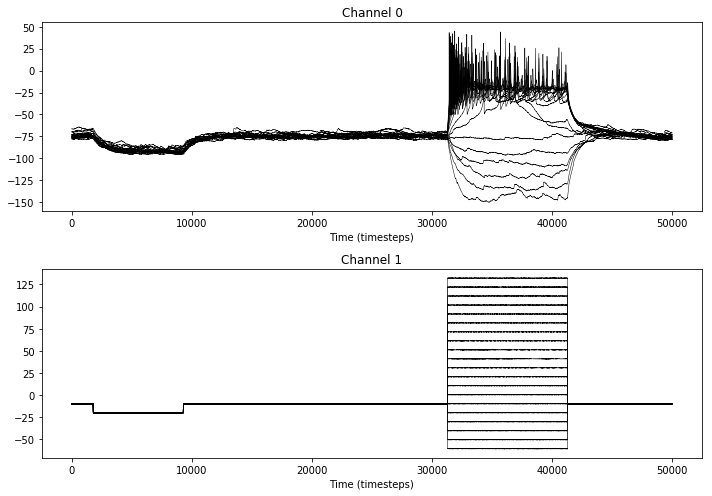

In [5]:
curr_steps = Cell().read_ABF([os.path.join(DATA_PATH, fn) for fn in fnames['Steps']])
curr_steps[0].plot()

Current step recordings have a similar structure, but differ in number of sweeps. Also possibly in spacing of current steps.

Automatically detect the start/end of the test pulse and current steps based on the first recording and then show whether this works for all cells.

In [6]:
change_threshold = 5. # pA threshold at which to detect a step.

tstpts = {}
mainpts = {}

try:
    tstpts['start'], mainpts['start'] = np.where(np.diff(curr_steps[0][1, :, 0]) < -change_threshold)[0]
    tstpts['stop'], mainpts['stop'] = np.where(np.diff(curr_steps[0][1, :, 0]) > change_threshold)[0]
except ValueError:
    print 'Too many or too few steps detected. Might need to adjust `change_threshold`.'
    raise

del change_threshold

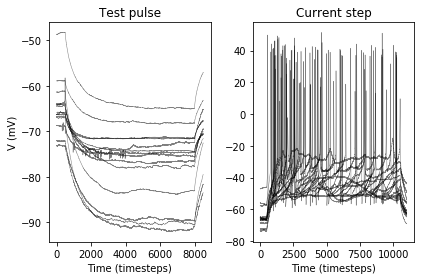

In [7]:
dt = 0.1 # ms. Assumed.

buffer_timesteps = 500

plt.figure()

tst_ax = plt.subplot(121)
tst_ax.set_title('Test pulse')

step_ax = plt.subplot(122)
step_ax.set_title('Current step')

for expt in curr_steps:
    tst_ax.plot(
        expt[0, (tstpts['start'] - buffer_timesteps):(tstpts['stop'] + buffer_timesteps), :].mean(axis = 1), 
        'k-', lw = 0.5, alpha = 0.5
    )
    step_ax.plot(
        expt[0, (mainpts['start'] - buffer_timesteps):(mainpts['stop'] + buffer_timesteps), 8], 
        'k-', lw = 0.5, alpha = 0.5
    )
    
tst_ax.set_xlabel('Time (timesteps)')
tst_ax.set_ylabel('V (mV)')

step_ax.set_xlabel('Time (timesteps)')
step_ax.set_ylabel('')

plt.tight_layout()

plt.show()

Quality control. Remove experiments where $I$ channel wasn't registered correctly. Cells being rejected are plotted, and number of retained cells is printed at the end.

In [8]:
qc_mask = []
for i, rec in enumerate(curr_steps):
    if (np.abs(rec[1, :, :] - np.mean(rec[1, :, :])) < 1.).all() :
        qc_mask.append(False)
        rec.plot()
    else:
        qc_mask.append(True)
        
curr_steps = [curr_steps[i] for i in range(len(curr_steps)) if qc_mask[i]]
print '{} of {} cells passed quality control.'.format(len(curr_steps), len(qc_mask))

del qc_mask

14 of 14 cells passed quality control.


## Extract passive parameters

In [9]:
passive_params = {'tau': [], 'R': [], 'E_est': []}

for i, rec in enumerate(curr_steps):
    
    tmp = rec[0, tstpts['start']:tstpts['stop'], :].mean(axis = 1)
    tmp_minmax = tmp.max() - tmp.min()
    
    bl_range = (int(tstpts['start']-105), int(tstpts['start']-5))
    
    # Extract tau and R.
    rec.set_dt(dt)
    params_tmp = rec.fit_test_pulse(
        bl_range, 
        (int(tstpts['stop'] - 105), int(tstpts['stop'] - 5)),
        V_clamp = False,
        V_chan = 0,
        I_chan = 1,
        tau = (
            tstpts['start'], 
            np.argmin(np.abs(0.8 * tmp_minmax + tmp.min() - tmp)) + tstpts['start'],
            np.argmin(np.abs(0.2 * tmp_minmax + tmp.min() - tmp)) + tstpts['start']
        ),
        plot_tau = False,
        verbose = False
    )
    
    # Store tau and R.
    passive_params['tau'].append(params_tmp['tau'])
    passive_params['R'].append(float(params_tmp['R_input'].mean()))
    
    # Estimate reversal potential
    I = rec[1, slice(*bl_range), :].mean()
    V = rec[0, slice(*bl_range), :].mean()
    passive_params['E_est'].append(V + (I * params_tmp['R_input'].mean()) * 1e-3)
    
passive_params = pd.DataFrame(passive_params)

# Calculate capacitance in pF
passive_params['C'] = passive_params['tau'] / passive_params['R'] * 1e3

del tmp, tmp_minmax, params_tmp, I, V

In [10]:
print 'passive_params shape: {}'.format(passive_params.shape)
passive_params.head()

passive_params shape: (14, 4)


,E_est,R,tau,C
0,-90.38250001023631,1779.230850,77.472911,43.542922
1,-97.40268322728699,1727.954450,102.737606,59.456200
2,-75.13233043085185,937.451473,88.340325,94.234558
3,-82.96586508417042,834.887758,40.185980,48.133393
4,-68.696882934417,508.006091,41.586178,81.861573


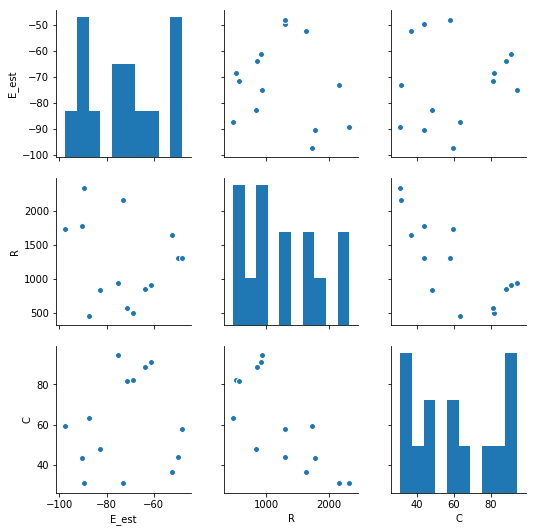

In [11]:
sns.pairplot(passive_params[[x for x in passive_params if x != 'tau']])

## Generate f/I curves

f/I curves are usually rectified linear. However, in some cases non-monotonic f/I curves are observed, usually due to depolarization block.

In [12]:
def detect_spikes(voltage_arr, threshold = 0., ref = 4., dt = 0.1):
    
    # Convert refractory period into index-based units
    ref_ind = int(np.round(ref/dt))

    # Detect points above or below threshold to get rising edges
    above_thresh = voltage_arr >= threshold
    below_thresh = ~above_thresh

    rising_edges = above_thresh[1:, :] & below_thresh[:-1, :]

    # Convert rising edges to spk inds
    spkwhere = np.where(rising_edges)
    
    spks = [[] for i in range(voltage_arr.shape[1])]
    
    for spktime, swnum in zip(spkwhere[0], spkwhere[1]):
        spks[swnum].append(spktime)

    # Remove points that reference the same spk, if any spks were detected
    for i in range(len(spks)):
        spks[i] = np.sort(spks[i])
        if len(spks[i]) >= 1:
            redundant_pts = np.where(np.diff(spks[i]) <= ref_ind)[0] + 1
            spks[i] = np.delete(spks[i], redundant_pts)

    return np.array(spks)


In [13]:
# Detect spikes in all recordings.
spktimes = [detect_spikes(rec[0, :, :]) for rec in curr_steps]

In [14]:
# Extract f/I data.

# Dict to hold output.
fi_data = {'f': [], 'I': [], 'CV': [], 'rheobase': [], 'coeffs': []}

# Throwaway function to detect whether an f/I curve increases monotonically.
is_monotonic = lambda x_: np.all(np.nan_to_num(np.diff(x_) / x_[:-1]) > -0.25)

for rec, times in zip(curr_steps, spktimes):
    
    spks_in_window = [x[np.logical_and(x >= mainpts['start'], x < mainpts['stop'])] * dt for x in times]
    ISIs_tmp = [np.diff(x) for x in spks_in_window]
    cv_tmp = [x.std() / x.mean() if len(x) > 0 else 0 for x in ISIs_tmp]
    
    f_tmp = np.array(
            [len(x) for x in spks_in_window]
        ) / (1e-3 * dt * (mainpts['stop'] - mainpts['start'])) # Convert to a rate in Hz.
    I_tmp = rec[1, (mainpts['stop'] - 1000):(mainpts['stop'] - 10), :].mean(axis = 0) # Scrape input current.
    
    try:
        rheobase_ind = np.where(f_tmp > 1e-4)[0][0]
    except IndexError:
        rec.plot()
        print f_tmp
        print times
        raise
    
    if is_monotonic(f_tmp):
        coeffs_tmp = np.polyfit(I_tmp[rheobase_ind:], f_tmp[rheobase_ind:], 1)
    else:
        coeffs_tmp = [np.nan for i in range(2)]
        
    fi_data['f'].append(f_tmp)
    fi_data['I'].append(I_tmp)
    fi_data['CV'].append(cv_tmp)
    fi_data['rheobase'].append(I_tmp[rheobase_ind])
    fi_data['coeffs'].append(coeffs_tmp)
    
fi_data['coeffs'] = np.array(fi_data['coeffs'])

/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


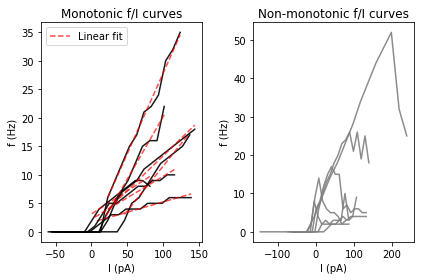

In [15]:
# Plot f/I curves.

plt.figure()

mono_curves = plt.subplot(121)
mono_curves.set_title('Monotonic f/I curves')

nonmono_curves = plt.subplot(122)
nonmono_curves.set_title('Non-monotonic f/I curves')

legend_flag = False
for x, y, coeffs in zip(fi_data['I'], fi_data['f'], fi_data['coeffs']):
    
    if is_monotonic(y):
        mono_curves.plot(x, y, 'k-', alpha = 0.9)
        
        if not legend_flag:
            mono_curves.plot(
                x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 'r--', alpha = 0.7,
                label = 'Linear fit'
            )
            legend_flag = True
        else:
            mono_curves.plot(x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 
                             'r--', alpha = 0.7)
    else:
        nonmono_curves.plot(x, y, '-', color = 'gray', alpha = 0.9)

mono_curves.legend()
mono_curves.set_xlabel('I (pA)')
mono_curves.set_ylabel('f (Hz)')

nonmono_curves.set_xlabel('I (pA)')
nonmono_curves.set_ylabel('f (Hz)')

plt.tight_layout()

plt.show()

Most of the cells have linear monotonic curves. Current steps of cells from the non-monotonic group are below.

/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


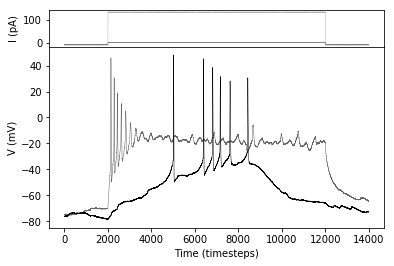

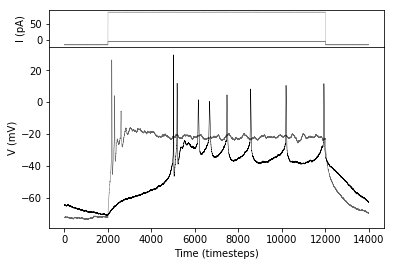

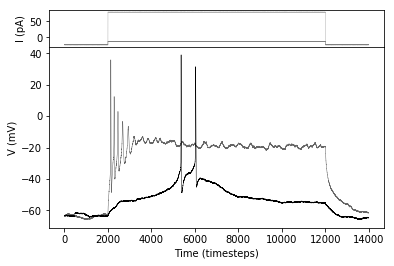

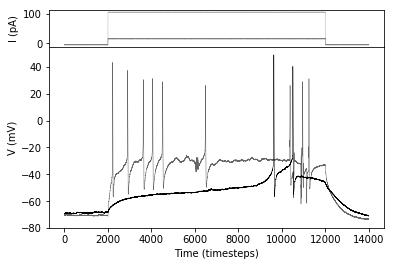

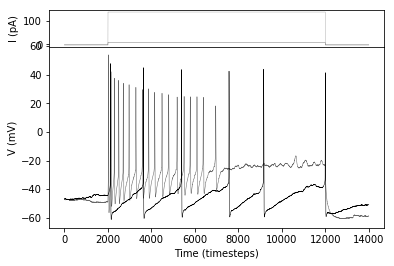

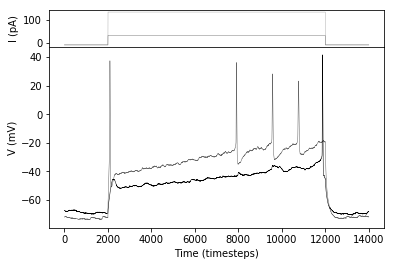

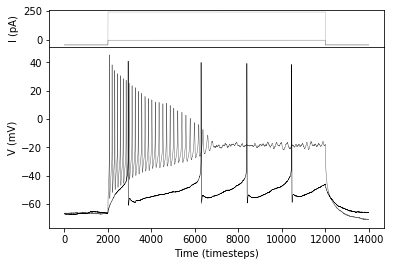

In [16]:
for y, rec in zip(fi_data['f'], curr_steps):
    if not is_monotonic(y):
        first_sweep_with_spikes = np.min(np.where(y > 0)[0])
        
        plt.figure()
        spec_tmp = gs.GridSpec(2, 1, height_ratios = [0.2, 1], hspace = 0)
        
        plt.subplot(spec_tmp[0, :])
        plt.plot(
            rec[1, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), first_sweep_with_spikes],
            '-', color = 'gray', lw = 0.5
        )
        plt.plot(
            rec[1, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), -1],
            '-', color = 'gray', lw = 0.5, alpha = 0.6
        )
        
        plt.ylabel('I (pA)')
        
        plt.subplot(spec_tmp[1, :])
        plt.plot(
            rec[0, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), first_sweep_with_spikes],
            'k-', lw = 0.5
        )
        plt.plot(
            rec[0, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), -1],
            'k-', lw = 0.5, alpha = 0.6
        )
        
        plt.ylabel('V (mV)')
        plt.xlabel('Time (timesteps)')
        
        plt.show()

Usually the cells have non-monotonic f/I curves because they go into depolarization block. In one case, it looks to be due to a weird 'either delayed or immediate' firing phenotype. The last cell went into depol. block because I pushed it harder than the others, which isn't very interesting.

## Compute a "burstiness" metric



In [17]:
cv_stats = {'min': [], 'Q1': [], 'median': [], 'Q3': [], 'max': [], 'range': []}
for x in fi_data['CV']:
    nonzero_CV = [i for i in x if i > 1e-3]
    
    cv_stats['min'].append(np.min(nonzero_CV))
    cv_stats['Q1'].append(np.percentile(nonzero_CV, 25))
    cv_stats['median'].append(np.median(nonzero_CV))
    cv_stats['Q3'].append(np.percentile(nonzero_CV, 75))
    cv_stats['max'].append(np.max(nonzero_CV))
    cv_stats['range'].append(np.max(x) - np.min(nonzero_CV))
    
cv_stats = pd.DataFrame(cv_stats)

del x, nonzero_CV

In [18]:
cv_stats.head()

,Q1,Q3,max,median,min,range
0,0.125550,0.845103,1.831330,0.501981,0.056734,1.774595
1,0.455449,0.883660,1.237459,0.529860,0.381038,0.856422
2,0.568700,0.698421,0.738459,0.625155,0.480010,0.258450
3,0.108700,0.275399,0.392882,0.183409,0.055446,0.337436
4,0.056011,0.111641,0.203936,0.094427,0.034043,0.169892


In [19]:
print 'Shapiro-Wilk normality tests\n'
print '{:>8}{:>8}{:>8}'.format('Metric', 'W', 'p')
print '{}'.format(''.join(['_'] * 8 * 3))
for col in cv_stats:
    W, p = stats.shapiro(cv_stats[col])
    print '{:>8}{:>8.3f}{:>8.3f}'.format(col, W, p)

Shapiro-Wilk normality tests

  Metric       W       p
________________________
      Q1   0.868   0.040
      Q3   0.913   0.175
     max   0.917   0.199
  median   0.875   0.050
     min   0.848   0.021
   range   0.897   0.103


/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'kind', 'label'
  s)


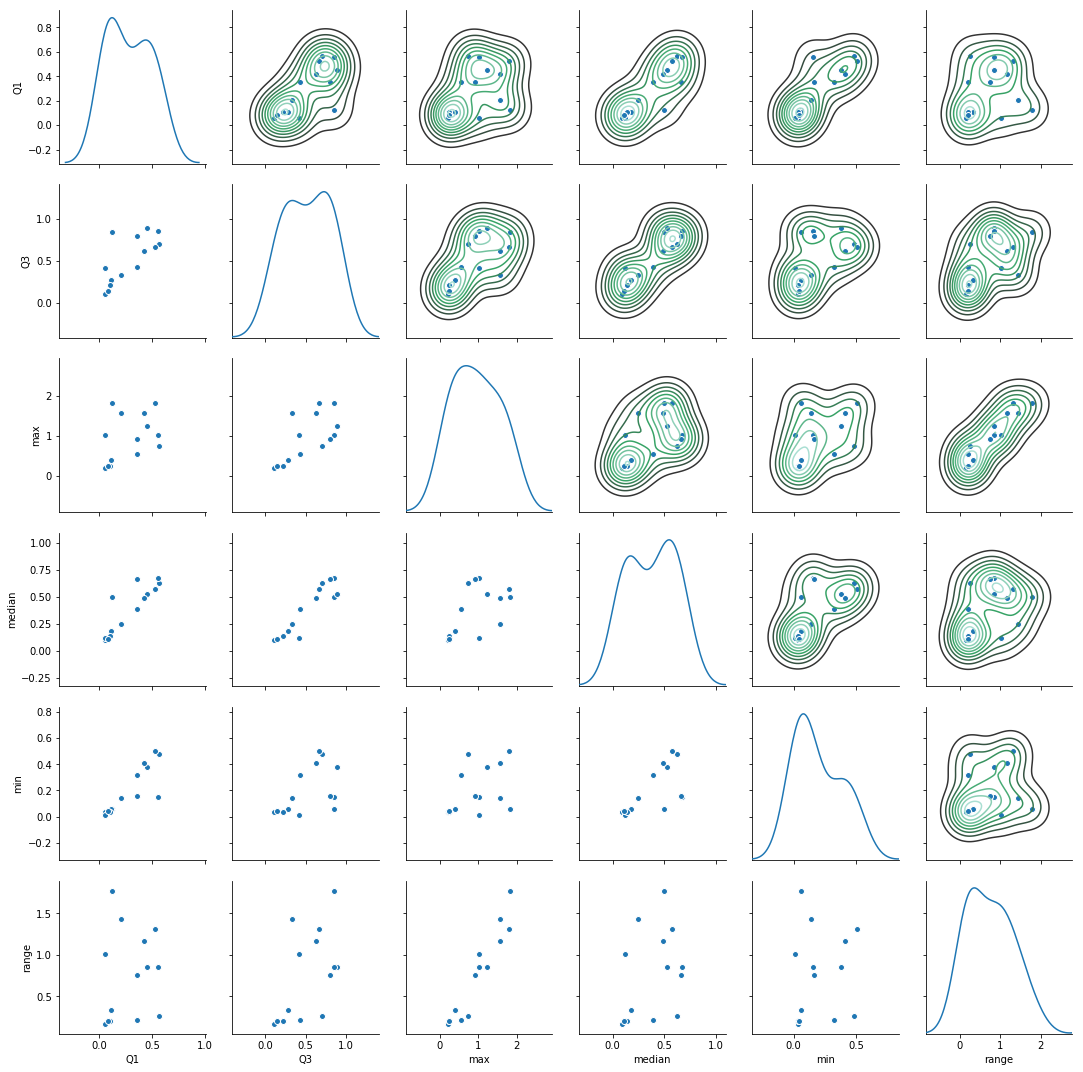

In [20]:
g = sns.pairplot(cv_stats, diag_kind = 'kde')
g.map_upper(sns.kdeplot, kind = 'contour')

## Dimensionality reduction

Assemble dataframe with all computed metrics for clustering.

### Prepare and inspect data

In [21]:
plotframe = pd.concat([cv_stats, passive_params], axis = 1)
plotframe['rheobase'] = fi_data['rheobase']
plotframe['is_monotonic'] = [int(is_monotonic(x)) for x in fi_data['f']]
plotframe['minfreq'] = [np.min(x[x>1e-3]) for x in fi_data['f']]

/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [22]:
# Normalize variables.
for colname in plotframe:
    plotframe[colname] -= plotframe[colname].mean()
    plotframe[colname] /= plotframe[colname].std()

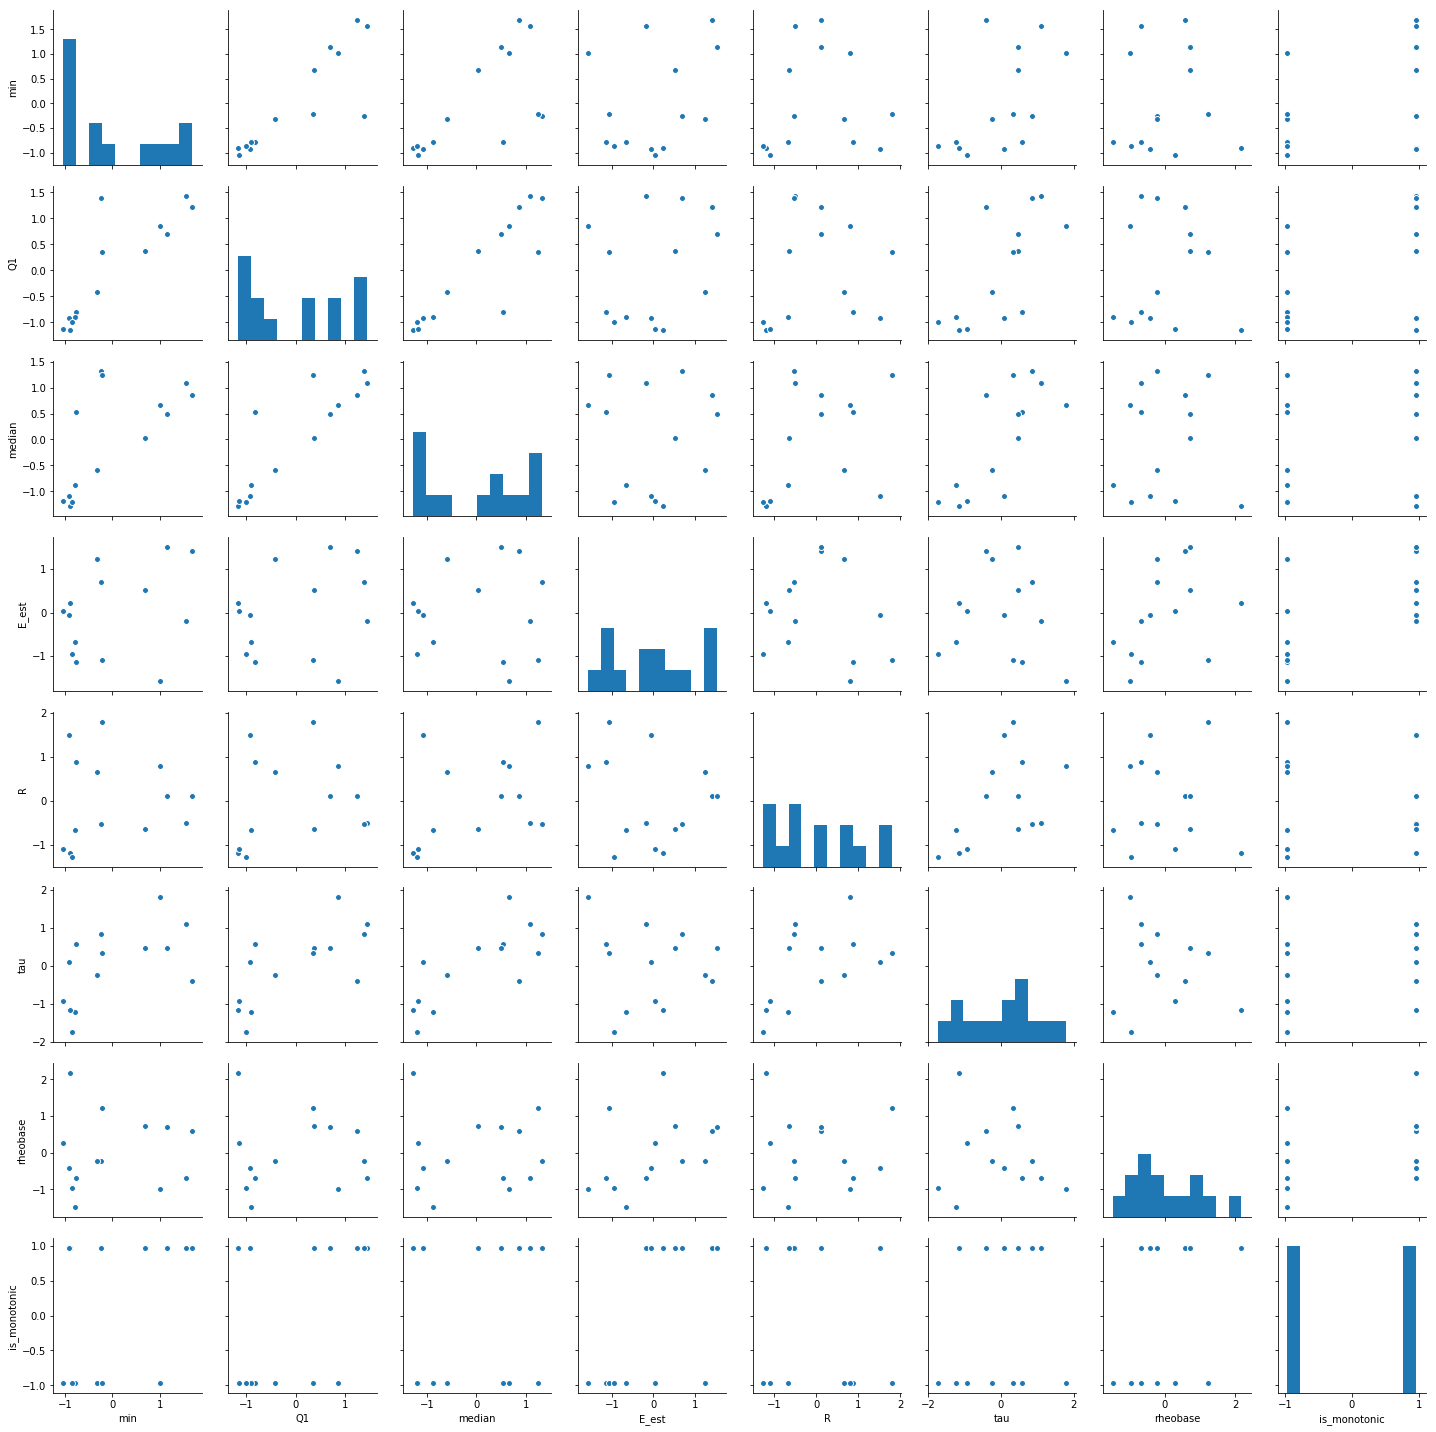

In [23]:
sns.pairplot(
    plotframe, 
    vars = ['min', 'Q1', 'median', 'E_est', 'R', 'tau', 'rheobase', 'is_monotonic']
)

Pairplot on a reduced set of features is hard to interpret.

A few observations:
- ISI CV quantiles are highly correlated with eachother.
- Tau and R are correlated (but R and C are anticorrelated, not shown).
- f/I curve monotonicity isn't strongly associated with anything.

### PCA

Even the pairplot on a reduced set of features is a bit overwhelming. Use PCA to get a clearer picture.

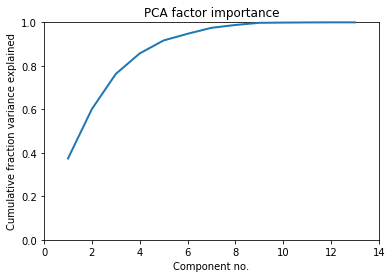

In [24]:
pca = PCA(n_components = plotframe.shape[1])
pca.fit(plotframe)
trans = pca.transform(plotframe)

plt.figure()
plt.subplot(111)
plt.title('PCA factor importance')
plt.plot(
    np.arange(1, pca.n_components + 1), 
    np.cumsum(pca.explained_variance_ratio_), 
    lw = 2, clip_on = False, zorder = 5
)
plt.ylim(0, 1)
plt.xlim(0, pca.n_components + 1)
plt.ylabel('Cumulative fraction variance explained')
plt.xlabel('Component no.')
plt.show()

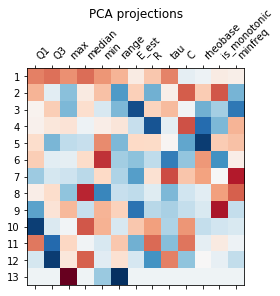

In [25]:
plt.figure()

ax = plt.subplot(111)
ax.set_title('PCA projections', pad = 40)
ax.matshow(pca.components_, cmap = plt.get_cmap('RdBu'))
ax.set_xticks(np.arange(pca.n_components))
ax.set_xticklabels(plotframe.columns, rotation = 45, ha = 'left')
ax.set_yticks(np.arange(pca.n_components))
ax.set_yticklabels(np.arange(1, pca.n_components + 1))

plt.show()

### Cluster on PCA projection

Look for clusters that may correspond to different firing phenotypes. Try with only two clusters on the first two principal components.

In [26]:
kclust = KMeans(2)
predictions = kclust.fit_predict(trans[:, :2])
pred_mask = predictions < 0.5 # Turn into a boolean mask, assuming 2 clusters.

Text(0,0.5,'2nd component')

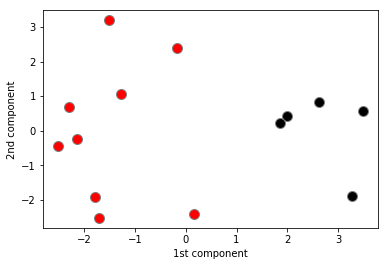

In [27]:
plt.plot(
    trans[pred_mask, 0], trans[pred_mask, 1], 
    'o', markeredgecolor = 'gray', markerfacecolor = 'k',
    markersize = 10, label = 'Cluster no. 1'
)
plt.plot(
    trans[~pred_mask, 0], trans[~pred_mask, 1], 
    'o', markeredgecolor = 'gray', markerfacecolor = 'r',
    markersize = 10, label = 'Cluster no. 2'
)
plt.xlabel('1st component')
plt.ylabel('2nd component')

Looks like clustering is pretty much determined by the value along the first principal component.

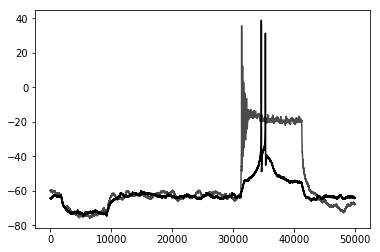

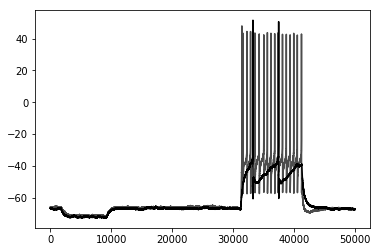

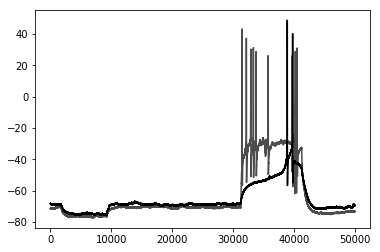

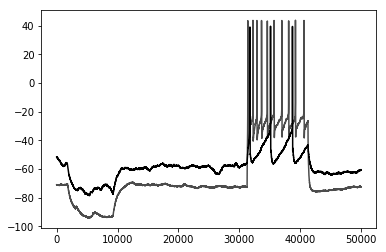

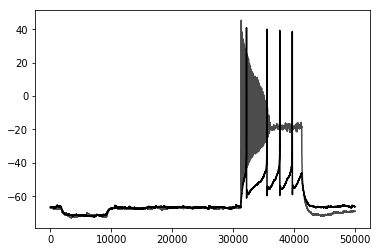

In [28]:
for i, rec in enumerate(curr_steps):
    
    if not pred_mask[i]:
        continue
    
    first_spk_ind = np.where(fi_data['f'][i] > 1.01)[0][0]
    
    plt.figure()
    plt.plot(rec[0, :, first_spk_ind], 'k-')
    plt.plot(rec[0, :, -1], 'k-', alpha = 0.7)
    plt.show()

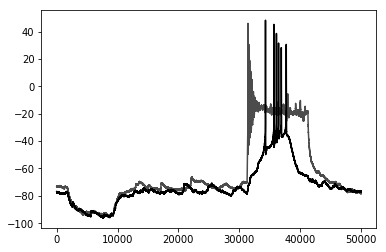

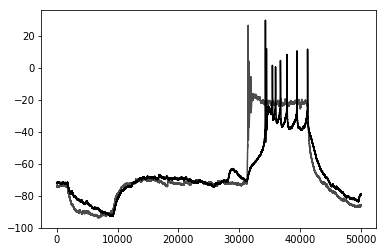

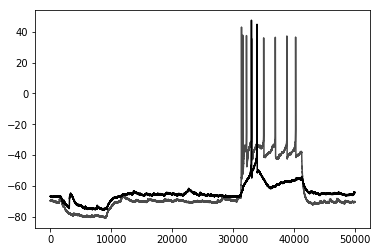

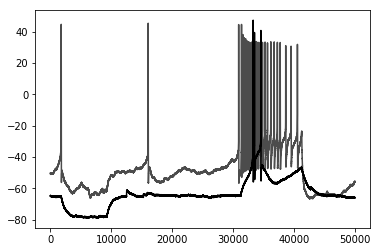

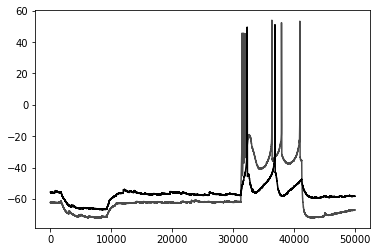

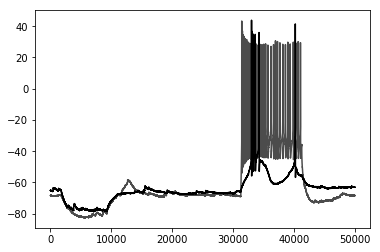

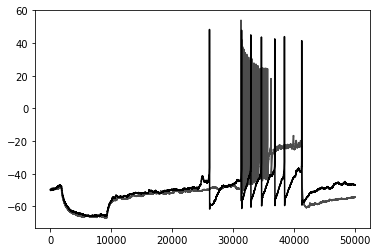

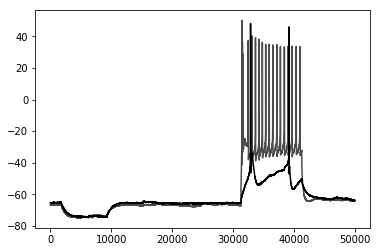

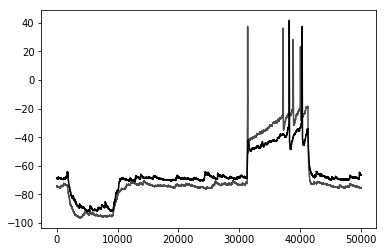

In [29]:
for i, rec in enumerate(curr_steps):
    
    if pred_mask[i]:
        continue
    
    first_spk_ind = np.where(fi_data['f'][i] > 1.01)[0][0]
    
    plt.figure()
    plt.plot(rec[0, :, first_spk_ind], 'k-')
    plt.plot(rec[0, :, -1], 'k-', alpha = 0.7)
    plt.show()

Unclear whether there's a meaningful difference between the two clusters. Certainly, bursty vs. non-bursty cells are not well separated.